# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Построем модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# План выполнения проекта
1. Проведем исследовательский анализ набора фотографий.
2. Подготовим данные к обучению.
3. Обучим нейронную сеть и рассчитаем её качество.

## Исследовательский анализ данных

Импортируем необходимые библиотеки.

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Сохраним датасет.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

В таблице 7591 фотография.

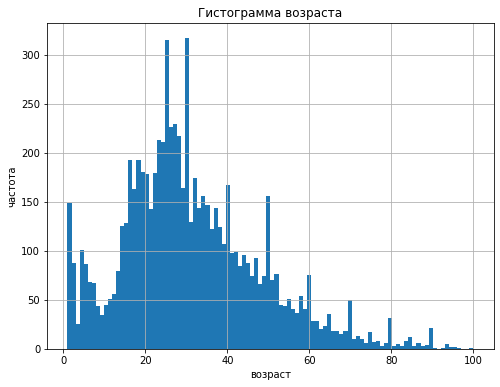

In [5]:
labels.hist(bins=100, figsize=(8,6))
plt.title('Гистограмма возраста')
plt.xlabel('возраст')
plt.ylabel('частота')
plt.show()

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Большая часть фотографий соотвествует возрасту от 20 до 41 года.

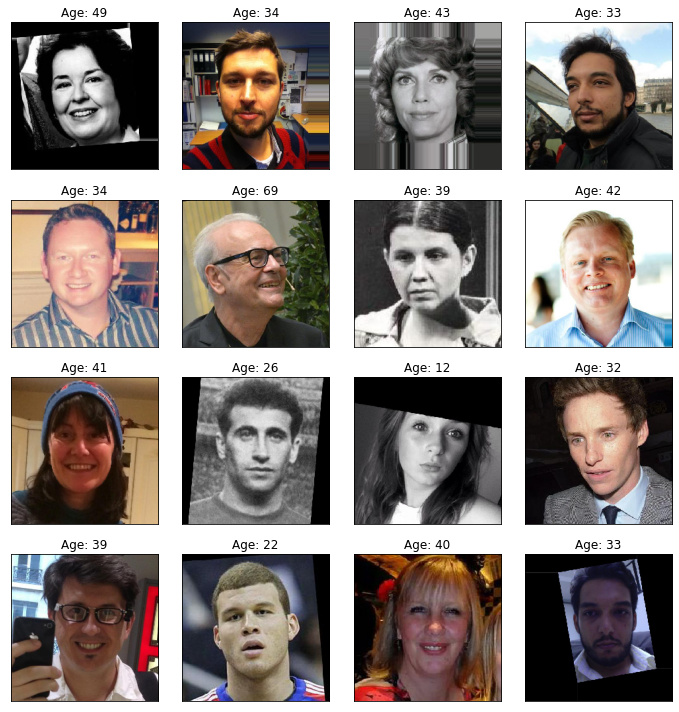

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()    

# Вывод по исследовательскому аналлизу 
1. В таблице 7591 фотография. Большая часть фотографий соотвествует возрасту от 20 до 41 года со смещением влево. С большим кол-вом примеров детей, чем пожилых людей.<br />
2. Имеются как цветные, так и ч/б фотографии, так же на многих присутсвует смещение на черном фоне. Люди изображены в разнаых положениях и с различным освещением.<br />
3. На фотографиях есть объекты заслоняющие лицо: очки, головные уборы, жвачки и т.д.<br />
4. Для повышения качества модели добавим аугментацию.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Создадим функции для загрузки тренировочных и тестовых данных, функцию по созданию нейронную сеть на основе ResNet50, а так же функцию по обучению модели.

```python

# < скопируйте код сюда >
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2024-02-19 01:06:57.158070: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-19 01:06:58.262004: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 70s - loss: 207.6644 - mae: 10.3903 - val_loss: 452.6291 - val_mae: 15.9990
Epoch 2/10
356/356 - 41s - loss: 85.3415 - mae: 6.9398 - val_loss: 140.8833 - val_mae: 9.1917
Epoch 3/10
356/356 - 41s - loss: 57.0279 - mae: 5.7822 - val_loss: 84.5527 - val_mae: 7.0260
Epoch 4/10
356/356 - 41s - loss: 42.9584 - mae: 5.0036 - val_loss: 83.1403 - val_mae: 6.8307
Epoch 5/10
356/356 - 41s - loss: 32.7888 - mae: 4.3661 - val_loss: 68.6576 - val_mae: 6.2929
Epoch 6/10
356/356 - 41s - loss: 24.3442 - mae: 3.7577 - val_loss: 72.3449 - val_mae: 6.2167
Epoch 7/10
356/356 - 41s - loss: 20.0005 - mae: 3.4330 - val_loss: 67.1694 - val_mae: 6.1132
Epoch 8/10
356/356 - 40s - loss: 16.1888 - mae: 3.0391 - val_loss: 80.3689 - val_mae: 6.7541
Epoch 9/10
356/356 - 41s - loss: 13.4335 - mae: 2.7938 - val_loss: 64.4939 - val_mae: 5.9692
Epoch 10/10
356/356 - 41s - loss: 13.1155 - mae: 2.7564 - val_loss: 66.2959 - val_mae: 6.2594


```

## Анализ обученной модели

Метрика МАЕ на тестовой выборке составила 6.2594 за 10 эпох обучения, это соответсвует требованию - MAE меньше 7. Нейронная сеть хорошо справляется с оценкой возраста по фотографиям.
 Возможно, задучу стоит перевести в класс классификации, сделать несколько груп людей (дети, взрослые, пожилые), т.к. для проверки на возможность продажи алкаголя точность в 6 лет оставляет желать лучшего. Так же стоит попробовать дополнительные аугментации и эпохи, это может повысить точность предсказания.